# Import Libraries

In [2]:
import re
import time
import random
import glob
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt

import requests
from bs4 import BeautifulSoup

from collections import Counter
from wordcloud import WordCloud

import ast
from langdetect import detect
import contractions
import nltk
from nltk.corpus import stopwords, names
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Scrape

In [21]:
chunk_no = 4 # TODO, change accordingly to chunk
df = pd.read_csv(f'songs_train_{chunk_no}.csv')
# df = pd.read_csv('songs_test.csv')

In [3]:
def get_lyric(url):
    try:
        response = requests.get(url)
        
        if response.status_code != 200:
            print(f'HTTP {response.status_code} error for URL: {url}')
            return None, None
        
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Inspect element, check span class of lyrics
        lyrics_spans = soup.find_all('span', class_='ReferentFragment-desktop-sc-380d78dd-1 iXIOUu')
        
        if lyrics_spans:
            lyrics_lines = [span.get_text(separator='\n').strip() for span in lyrics_spans]
            # Get rid of [Verse n], [Chorus], etc
            lyrics = '\n'.join([line for line in lyrics_lines if not re.match(r'^\[.*\]$', line)])
        else:
            lyrics = 'Lyrics not found'
        
        # Inspect element, get views count from title
        views_span = soup.find('span', title=lambda value: value and 'views' in value.lower())
        views = int(views_span['title'].replace(' views', '').replace(',', '')) if views_span else 'Views not found'
        
        time.sleep(random.uniform(0.25, 0.75))
        
        return lyrics, views
        
    except Exception as e:
        print(f'Error for {url}, got {e}')
        return None, None

In [ ]:
tqdm.pandas()
df[['lyric', 'views']] = df['url'].progress_apply(lambda url: get_lyric(url)).apply(pd.Series)

In [23]:
df['lyric'].isna().sum()

369

In [24]:
df.to_csv(f'songs_train_scraped_{chunk_no}.csv', index=False)
# df.to_csv(f'songs_test_scraped.csv', index=False)

# Concat

Concat all chunked CSV (songs_train_scraped_{num}.csv)

In [29]:
train_dfs = [pd.read_csv(file) for file in glob.glob('songs_train_scraped_*.csv')]

In [33]:
df_train = pd.concat(train_dfs, ignore_index=True)
df_train.to_csv('songs_train_scraped.csv', index=False)

In [35]:
df_test = pd.read_csv('songs_test_scraped.csv')
df_train = pd.read_csv('songs_train_scraped.csv')
print('df_train shape: ', df_train.shape)
print('df_test shape: ', df_test.shape)

df_train shape:  (9000, 6)
df_test shape:  (1000, 6)


# Clean

Clean the dataset, drop for url unavailable (NaN) and rerun with different script for 'lyrics not found'

In [46]:
df_train['lyric'].isnull().value_counts()

lyric
False    7367
Name: count, dtype: int64

In [47]:
df_test['lyric'].isnull().value_counts()

lyric
False    811
Name: count, dtype: int64

In [45]:
df_train.dropna(subset=['lyric'], inplace=True)
df_test.dropna(subset=['lyric'], inplace=True)

In [53]:
df_train[df_train['lyric'] == 'Lyrics not found'].shape[0]

0

In [54]:
df_test[df_test['lyric'] == 'Lyrics not found'].shape[0]

0

In [50]:
def get_lyric_notfound(url):
    try:
        response = requests.get(url)
        
        if response.status_code != 200:
            print(f'HTTP {response.status_code} error for URL: {url}')
            return None, None
        
        soup = BeautifulSoup(response.text, 'html.parser')
        
        # Find the div that contains the lyrics
        lyrics_div = soup.find("div", {"data-lyrics-container": "true"})
        
        if lyrics_div:
            lyrics_lines = list(lyrics_div.stripped_strings)
            # Get rid of [Verse n], [Chorus], etc
            lyrics = "\n".join([line for line in lyrics_lines if not re.match(r'^\[.*\]$', line)])
        else:
            print('Lyrics not found for ', url)
            lyrics = 'Lyrics not found'
        
        time.sleep(random.uniform(0.25, 0.75))
        
        return lyrics
    except Exception as e:
        print(f'Error for {url}, got {e}')
        return None

In [51]:
tqdm.pandas()
df_train.loc[df_train['lyric'] == 'Lyrics not found', 'lyric'] = df_train.loc[df_train['lyric'] == 'Lyrics not found', 'url'].progress_apply(get_lyric_notfound)

100%|██████████| 274/274 [13:06<00:00,  2.87s/it]


In [52]:
tqdm.pandas()
df_test.loc[df_test['lyric'] == 'Lyrics not found', 'lyric'] = df_test.loc[df_test['lyric'] == 'Lyrics not found', 'url'].progress_apply(get_lyric_notfound)

100%|██████████| 35/35 [01:51<00:00,  3.18s/it]


In [55]:
print('df_train shape: ', df_train.shape)
print('df_test shape: ', df_test.shape)

df_train shape:  (7367, 6)
df_test shape:  (811, 6)


In [68]:
print('train views not found: ', df_train[df_train['views'] == 'Views not found'].shape[0])
print('test views not found: ', df_test[df_test['views'] == 'Views not found'].shape[0])

train views not found:  0
test views not found:  0


In [67]:
df_train.drop(df_train[df_train['views'] == 'Views not found'].index, inplace=True)

In [75]:
# Convert views to int
df_train['views'] = pd.to_numeric(df_train['views'].str.replace(',', ''), errors='coerce').astype('Int64')
df_test['views'] = df_test['views'].fillna(0).astype(int)

In [77]:
df_train.to_csv('songs_train_clean.csv', index=False)
df_test.to_csv('songs_test_clean.csv', index=False)

# Simple EDA

Pada bagian EDA, data yang akan diterapkan adalah dataset songs_train_clean.csv

In [81]:
df = pd.read_csv('songs_train_clean.csv')
df.head()

,title,artist,year,views,url,lyric
0,Untitled,Rex Orange County,2017,292064,https://genius.com/Rex-Orange-County-Untitled-...,So if for any reason there's some miscommunica...
1,Dandelions,Ruth B.,2017,587288,https://genius.com/Ruth-B-Dandelions-lyrics,Maybe it's the way you say my name\nMaybe it's...
2,I Like,G Herbo,2017,204698,https://genius.com/G-Herbo-I-Like-lyrics,"Pull up in a new G-Wag'\nSky blue body paint, ..."
3,Kiss Me,Ed Sheeran,2011,434377,https://genius.com/Ed-Sheeran-Kiss-Me-lyrics,"Yeah, I've been feelin' everything\nFrom hate ..."
4,I Say A Little Prayer,Aretha Franklin,1968,401893,https://genius.com/Aretha-Franklin-I-Say-A-Lit...,(I say a little prayer for you)\nThe moment I ...


In [84]:
temp = pd.read_csv('songs_train.csv')

In [93]:
print('Top 5 lagu yang paling banyak dilihat')
print(df.nlargest(5, 'views')[['title', 'artist', 'views']])

Top 5 lagu yang paling banyak dilihat
              title          artist     views
304         Rap God          Eminem  19681390
1062            WAP         Cardi B  16674232
4283   Shape of You      Ed Sheeran  15472314
3230  Lose Yourself          Eminem  15371462
7045        HUMBLE.  Kendrick Lamar  12050231


In [88]:
print(df.describe())

              year         views
count  7366.000000  7.366000e+03
mean   2010.412707  7.230816e+05
std      30.030646  9.597810e+05
min       1.000000  6.385000e+03
25%    2011.000000  2.920908e+05
50%    2015.000000  4.244805e+05
75%    2018.000000  7.512770e+05
max    2023.000000  1.968139e+07


In [92]:
print('Top 10 artis dengan kemunculan terbanyak')
print(df['artist'].value_counts().head(10))

Top 10 artis dengan kemunculan terbanyak
artist
Drake                          199
Eminem                         169
Kanye West                     138
The Weeknd                     101
Genius English Translations     83
Tyler, The Creator              83
J. Cole                         81
Taylor Swift                    76
Lana Del Rey                    69
Mac Miller                      67
Name: count, dtype: int64


In [91]:
print('Artis dengan view terbanyak')
print(df.groupby('artist')['views'].sum().sort_values(ascending=False).head(10))

Artis dengan view terbanyak
artist
Drake                 277588383
Eminem                222879143
Kanye West            164511224
The Weeknd            118788739
Kendrick Lamar        117044552
J. Cole                84213482
Taylor Swift           73692851
XXXTENTACION           65977448
Frank Ocean            65617722
Tyler, The Creator     60964489
Name: views, dtype: int64


<Axes: title={'center': 'Songs Released Per Year'}, xlabel='year'>

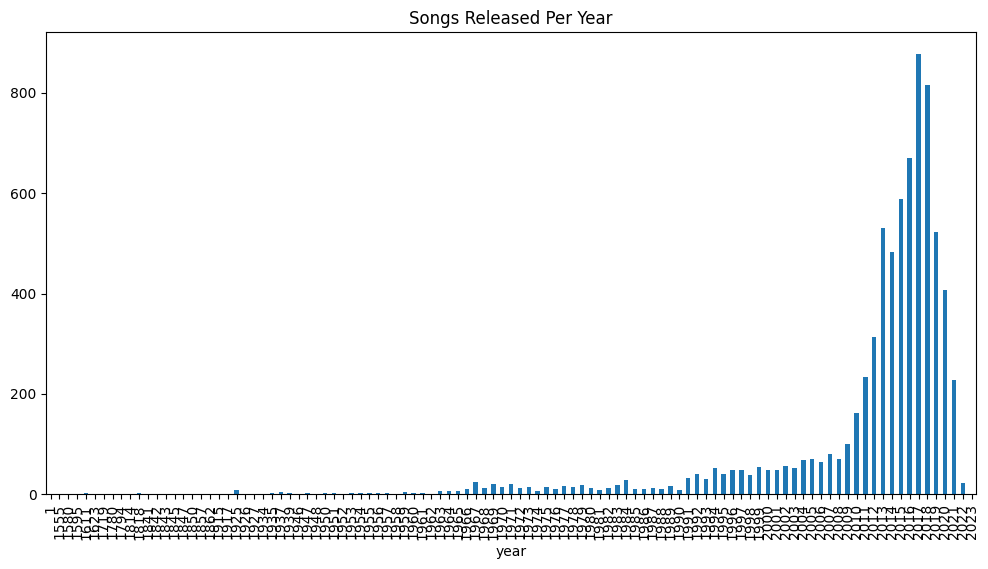

In [113]:
df['year'].value_counts().sort_index().plot(kind='bar', figsize=(12,6), title="Songs Released Per Year")

In [101]:
df['word_count'] = df['lyric'].apply(lambda x: len(str(x).split()))
print('Lagu dengan kata terbanyak')
print(df.nlargest(5, 'word_count')[['title', 'artist', 'word_count']])

Lagu dengan kata terbanyak
                             title               artist  word_count
4054       Producer Tags Directory           Rap Genius        7244
7075    The Great Gatsby Chapter I  F. Scott Fitzgerald        5273
2862  The Great Gatsby Chapter VII  F. Scott Fitzgerald        4700
1731      A Christmas Carol Part 1      Charles Dickens        3902
1899  The Great Gatsby Chapter III  F. Scott Fitzgerald        3721


In [3]:
# Untuk ini, menggunakan data dengan lyrics yang dihilangkan stop words dari songs_train_preprocessed.pkl
df_clean = pd.read_pickle('songs_train_preprocessed.pkl')

all_words_clean = [word for tokens in df_clean['tokens'] for word in tokens]
word_counts_clean = Counter(all_words_clean)
word_counts_clean.most_common(30) 

[('like', 18572),
 ('got', 12763),
 ('yeah', 12375),
 ('know', 12269),
 ('nigga', 9560),
 ('want', 9121),
 ('get', 9108),
 ('love', 7418),
 ('bitch', 5928),
 ('one', 5728),
 ('let', 5439),
 ('shit', 5426),
 ('time', 5401),
 ('never', 5309),
 ('fuck', 5147),
 ('back', 5077),
 ('see', 5056),
 ('say', 4945),
 ('make', 4794),
 ('would', 4757),
 ('baby', 4578),
 ('come', 4261),
 ('man', 4185),
 ('girl', 3987),
 ('take', 3946),
 ('feel', 3822),
 ('way', 3786),
 ('going', 3746),
 ('could', 3715),
 ('need', 3679)]

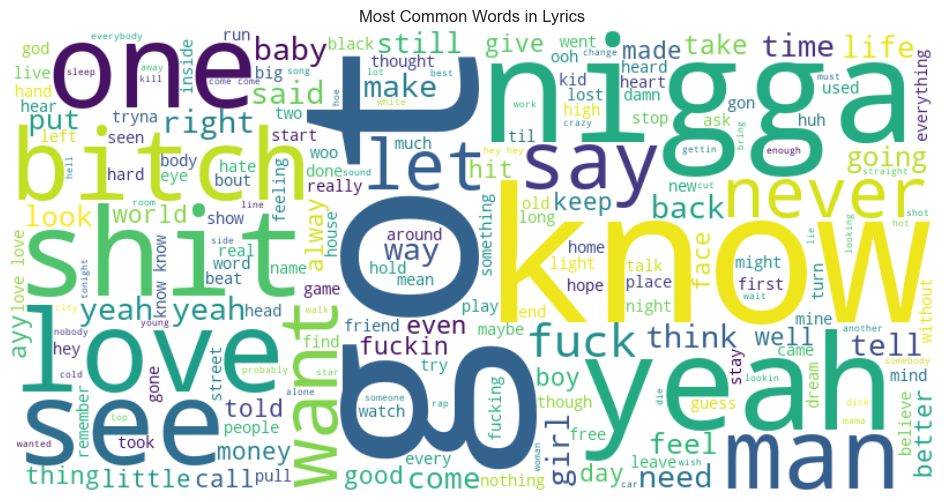

In [18]:
# Untuk ini, menggunakan data dengan lyrics yang dihilangkan stop words dari songs_train_preprocessed.pkl
all_words_clean_str = " ".join(all_words_clean)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(all_words_clean_str)
plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Most Common Words in Lyrics")
plt.show()

In [109]:
df[['word_count', 'views']].corr()

,word_count,views
word_count,1.000000,0.176074
views,0.176074,1.000000


In [110]:
df[['year', 'views']].corr()

,year,views
year,1.000000,-0.019397
views,-0.019397,1.000000


# Pre-Process

In [4]:
df = pd.read_csv('songs_train_clean.csv')
df_test = pd.read_csv('songs_test_clean.csv')

In [13]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('names')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
name_list = set(names.words())

def expand_contradictions(text):
    return contractions.fix(text)

def repeated_letters(word):
    if word.lower() in name_list:
        return word
    return re.sub(r'(.)\1{2,}', r'\1\1', word)

def tokenize(text):
  return word_tokenize(text)

def normalize(text):
  text = text.lower()
  text = re.sub(r'[^\w\s]', '', text)
  text = re.sub(r'\d+', '', text)
  return text

def remove_stopwords(tokens):
  return [word for word in tokens if word not in stop_words]

def lemmatization(tokens):
  return [lemmatizer.lemmatize(word) for word in tokens]

def remove_short_words(tokens):
  return [word for word in tokens if len(word) >= 3]

def is_english(text):
  try:
    return detect(text) == "en"
  except:
    return False

def preprocess_dataframe(df):
  df = df[df['lyric'].apply(is_english)]
  df['lyric_proccessed'] = df['lyric'].apply(expand_contradictions)
  df['lyric_proccessed'] = df['lyric_proccessed'].apply(normalize)
  df['tokens'] = df['lyric_proccessed'].apply(tokenize)
  df['tokens'] = df['tokens'].apply(lambda tokens: [repeated_letters(word) for word in tokens])
  df['tokens'] = df['tokens'].apply(lemmatization)
  df['tokens'] = df['tokens'].apply(remove_stopwords)
  df['tokens'] = df['tokens'].apply(remove_short_words)

  return df

def convert_string_to_list(text):
    try:
        return ast.literal_eval(text) if isinstance(text, str) else text
    except:
        return []

[nltk_data] Downloading package punkt to C:\Users\ahmad
[nltk_data]     hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to C:\Users\ahmad
[nltk_data]     hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\ahmad
[nltk_data]     hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\ahmad
[nltk_data]     hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package names to C:\Users\ahmad
[nltk_data]     hanif\AppData\Roaming\nltk_data...
[nltk_data]   Package names is already up-to-date!


In [14]:
df = preprocess_dataframe(df)
df_test = preprocess_dataframe(df_test)
df['tokens'] = df['tokens'].apply(convert_string_to_list)
df_test['tokens'] = df_test['tokens'].apply(convert_string_to_list)

C:\Users\ahmad hanif\AppData\Local\Temp\ipykernel_11712\2717322337.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lyric_proccessed'] = df['lyric'].apply(expand_contradictions)
C:\Users\ahmad hanif\AppData\Local\Temp\ipykernel_11712\2717322337.py:46: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['lyric_proccessed'] = df['lyric_proccessed'].apply(normalize)
C:\Users\ahmad hanif\AppData\Local\Temp\ipykernel_11712\2717322337.py:47: SettingWithCopyWarning: 
A value is trying to be set on a copy of a

In [15]:
df.head()

,title,artist,year,views,url,lyric,lyric_proccessed,tokens
0,Untitled,Rex Orange County,2017,292064,https://genius.com/Rex-Orange-County-Untitled-...,So if for any reason there's some miscommunica...,so if for any reason there is some miscommunic...,"[reason, miscommunication, lying, face, immatu..."
1,Dandelions,Ruth B.,2017,587288,https://genius.com/Ruth-B-Dandelions-lyrics,Maybe it's the way you say my name\nMaybe it's...,maybe it is the way you say my name\nmaybe it ...,"[maybe, way, say, name, maybe, way, play, game..."
2,I Like,G Herbo,2017,204698,https://genius.com/G-Herbo-I-Like-lyrics,"Pull up in a new G-Wag'\nSky blue body paint, ...",pull up in a new gwag\nsky blue body paint soo...,"[pull, new, gwag, sky, blue, body, paint, soow..."
3,Kiss Me,Ed Sheeran,2011,434377,https://genius.com/Ed-Sheeran-Kiss-Me-lyrics,"Yeah, I've been feelin' everything\nFrom hate ...",yeah i have been feelin everything\nfrom hate ...,"[yeah, feelin, everything, hate, love, love, l..."
4,I Say A Little Prayer,Aretha Franklin,1968,401893,https://genius.com/Aretha-Franklin-I-Say-A-Lit...,(I say a little prayer for you)\nThe moment I ...,i say a little prayer for you\nthe moment i wa...,"[say, little, prayer, moment, wake, put, makeu..."


In [11]:
df.to_pickle("songs_train_preprocessed.pkl")
df_test.to_pickle("songs_test_preprocessed.pkl")

Lyric vectorizing with Bag of Words (BOW)

In [61]:
df = pd.read_pickle('songs_train_preprocessed.pkl')
df_test = pd.read_pickle('songs_test_preprocessed.pkl')

In [63]:
def generate_bow_from_tokens(df, column_name="tokens"):
    tokenized_texts = df[column_name].apply(lambda x: ' '.join(x))
    vectorizer = CountVectorizer()
    X_bow = vectorizer.fit_transform(tokenized_texts)
    df_bow = pd.DataFrame(X_bow.toarray(), columns=vectorizer.get_feature_names_out())
    return df_bow

In [64]:
train_bow = generate_bow_from_tokens(df)
test_bow = generate_bow_from_tokens(df_test)

In [65]:
print(train_bow)

      ___ing  aaa  aaaa  aaaaaaaalchemist  aaaaaaack  aaaaah  aaaaamadeus  \
0          0    0     0                 0          0       0            0   
1          0    0     0                 0          0       0            0   
2          0    0     0                 0          0       0            0   
3          0    0     0                 0          0       0            0   
4          0    0     0                 0          0       0            0   
...      ...  ...   ...               ...        ...     ...          ...   
7302       0    0     0                 0          0       0            0   
7303       0    0     0                 0          0       0            0   
7304       0    0     0                 0          0       0            0   
7305       0    0     0                 0          0       0            0   
7306       0    0     0                 0          0       0            0   

      aaaalalalalalchemist  aaadam  aaah  ...  이기든지든  자체발광  잡으면  지구를  진실이  

TF-IDF

In [66]:
def generate_tfidf_from_tokens(df, column_name="tokens"):
    tokenized_texts = df[column_name].apply(lambda x: ' '.join(x)).replace('', None)
    df = df[tokenized_texts.notna()]
    vectorizer = TfidfVectorizer(max_features=5000)  
    X_tfidf = vectorizer.fit_transform(tokenized_texts.dropna())
    df_tfidf = pd.DataFrame(X_tfidf.toarray(), columns=vectorizer.get_feature_names_out())

    return df_tfidf

In [68]:
train_tfidf = generate_tfidf_from_tokens(df)
test_tfidf = generate_tfidf_from_tokens(df_test)

In [69]:
print(train_tfidf.head())

   aaliyah  aall  aap  abandoned  able  abortion  absolutely  abuse  accent  \
0      0.0   0.0  0.0        0.0   0.0       0.0         0.0    0.0     0.0   
1      0.0   0.0  0.0        0.0   0.0       0.0         0.0    0.0     0.0   
2      0.0   0.0  0.0        0.0   0.0       0.0         0.0    0.0     0.0   
3      0.0   0.0  0.0        0.0   0.0       0.0         0.0    0.0     0.0   
4      0.0   0.0  0.0        0.0   0.0       0.0         0.0    0.0     0.0   

   accept  ...  yuh  yung  yup  zero  zion  zip  zombie  zone  zoo  zoom  
0     0.0  ...  0.0   0.0  0.0   0.0   0.0  0.0     0.0   0.0  0.0   0.0  
1     0.0  ...  0.0   0.0  0.0   0.0   0.0  0.0     0.0   0.0  0.0   0.0  
2     0.0  ...  0.0   0.0  0.0   0.0   0.0  0.0     0.0   0.0  0.0   0.0  
3     0.0  ...  0.0   0.0  0.0   0.0   0.0  0.0     0.0   0.0  0.0   0.0  
4     0.0  ...  0.0   0.0  0.0   0.0   0.0  0.0     0.0   0.0  0.0   0.0  

[5 rows x 5000 columns]
